# <b>IMDb Sentiment Analysis with LSTM</b>
This notebook implements an LSTM model for sentiment analysis on IMDb reviews

# # 1. Setup and Imports
First, let's import all required libraries and modules.

Sequential : used to input nueral network layers in a sequential order
Embedding : layer used to convert words into vector embeddings
LSTM : layer used to simulate a LSTM nueral network
Dropout : layer used to drop some nuerons to introduce randomness and avoid overfitting
Bidirectional : layer used to traverse the sequence twice i.e. front to end and end to front

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# # 2. Data Processing and Importing

In [3]:
# Load data
df = pd.read_csv('../../data/raw/IMDB Dataset.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Clean text function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [5]:
# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [6]:
# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 35000
Validation size: 7500
Test size: 7500


In [7]:
#  First, ensure your tokenizer is properly initialized
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_review'])

#  When converting texts to sequences, cap indices at num_words-1
def texts_to_sequences_capped(tokenizer, texts):
    seq = tokenizer.texts_to_sequences(texts)
    return [[min(i, tokenizer.num_words - 1) for i in s] for s in seq]

#  Apply to all your data
train_sequences = texts_to_sequences_capped(tokenizer, train_df['cleaned_review'])
val_sequences = texts_to_sequences_capped(tokenizer, val_df['cleaned_review'])

In [8]:
max_length = 200
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')

#  Verify no indices exceed vocab size
print(f"Max index in train: {np.max(train_padded)}")  # Should be 19999
print(f"Max index in val: {np.max(val_padded)}")    # Should be 19999

Max index in train: 19999
Max index in val: 19999


In [10]:
# Save tokenizer for later use
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


# # 3. Model Building

In [11]:
# Define the LSTM architecture
# 1. Limit vocabulary size in Tokenizer (add this when creating tokenizer)
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')  # Top 20,000 words only

# 2. Update model building (remove input_length)
def build_lstm_model(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Removed input_length
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(lstm_units//2)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 3. Explicitly build the model by passing a sample input
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {min(vocab_size, 20000)}")  # Will use max 20,000 due to Tokenizer

model = build_lstm_model(min(vocab_size, 20000))  # Ensure we don't exceed num_words
model.build((None, 200))  # Explicitly build for 200-length sequences
model.summary()


Vocabulary size: 1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,385 (564.00 KB)

 Trainable params: 144,385 (564.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the LSTM model with early stopping
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [15]:
vocab_size = tokenizer.num_words 
model = build_lstm_model(vocab_size)
model.build((None, max_length))  


history = model.fit(
    train_padded,
    train_df['sentiment_label'].values,
    validation_data=(val_padded, val_df['sentiment_label'].values),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 105s 184ms/step - accuracy: 0.7005 - loss: 0.5470 - val_accuracy: 0.8716 - val_loss: 0.3113
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 194ms/step - accuracy: 0.8911 - loss: 0.2855 - val_accuracy: 0.8580 - val_loss: 0.3400
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 154s 282ms/step - accuracy: 0.9345 - loss: 0.1841 - val_accuracy: 0.8719 - val_loss: 0.3652
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 214s 391ms/step - accuracy: 0.9594 - loss: 0.1248 - val_accuracy: 0.8393 - val_loss: 0.5662


# # 5. Evaluation and Visualization
Analyze the model performance

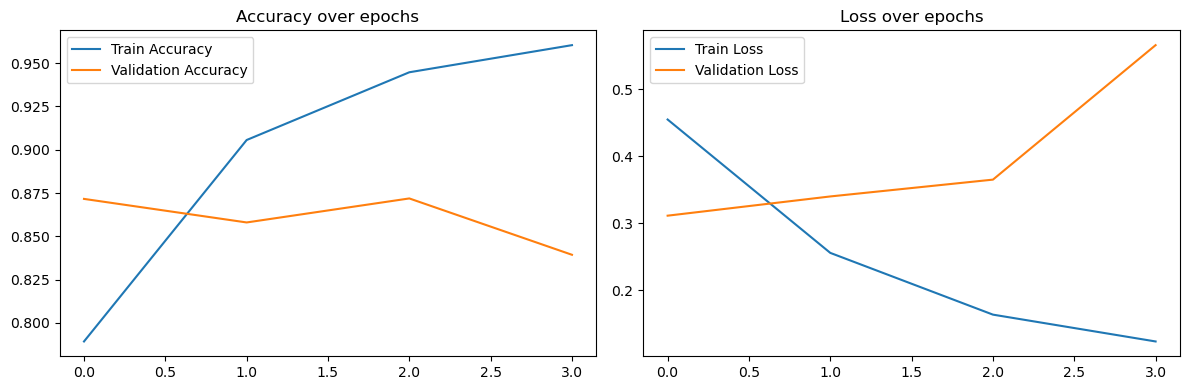

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.tight_layout()
plt.savefig('../../models/lstm/training_history.png')
plt.show()


# # 6. Prediction Function
Create a function to make predictions on new text

In [27]:
def predict_sentiment(text, max_length=200):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])

    if sequence is None or len(sequence[0]) == 0:
        print("Warning: No known words in input text.")
        padded = np.zeros((1, max_length), dtype=int)
    else:
        padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    prediction = model.predict(padded)[0][0]
    sentiment = 'positive' if prediction >= 0.5 else 'negative'
    confidence = prediction if sentiment == 'positive' else 1 - prediction

    print(f"Text: {text[:200]}...")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2%})")
    return sentiment, confidence
